# Generating heatmaps based on DBTL0 proteomics data

- Requires DBTL0 Top3 proteomics data
- Converts proteomics Protein.Groups into Locus names for familiarity
- Performs a t-test between control and sgRNA downregulation for a set of "samples of interest"
    - Samples are drawn from the parent-child analysis in Figure 4, which are also the most abundant sgRNAs from the cycles overall
    - Thresholds are set for:
        - Top3 proteomics cut-off for the control strains <b>(>0.001%)
        - Significance Threshold <b>(p-value < 0.05)
        - Fold-change Threshold <b>(FC = 0 for all significant proteins; FC = 1 for typical volcano)

#### 1) Curate notebook for proteomics Data
- Import libraries
- Import data
- Set Figure_Data folder for import
- Set Figure_Export folder for plots
- Translate gene names into locus names

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
input_dir = r'Figure_Data'
output_dir = r'Figure_Export'

In [3]:
# Formatted in the event multiple DBTL files are used
filenames = [f'DBTL{0}.csv']
input_paths = [os.path.join(input_dir, filename) for filename in filenames]

# Load CSVs and concatenate multiple files if necessary
dataframes = [pd.read_csv(input_path) for input_path in input_paths]
combined_df = pd.concat(dataframes, ignore_index=True)

In [4]:
# Translation file between gene names
name_df = pd.read_csv(f'{input_dir}/proteomics_id_translator_240305.csv') 

# primary_name is the common name whereas 'locus' is the PP_####; this is usually better for the output
translator_dict = pd.Series(name_df['primary_name'].values, index=name_df['extracted']).to_dict()  # proteomics -> common name
translator_dict2 = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()        # proteomics -> locus

def map_protein_group(protein_group):
    # proteomics -> common name
    primary_name = translator_dict.get(protein_group)
    if pd.notna(primary_name) and primary_name.strip():  # Check if primary_name is a non-blank string
        return primary_name
    
    # proteomics -> locus
    locus = translator_dict2.get(protein_group)
    if pd.notna(locus) and locus.strip():  # Check if locus is a non-blank string
        return locus

# Map Protein.Group from proteomics to Locus
combined_df['Protein.Group'] = combined_df['Protein.Group'].map(map_protein_group)

# Count the number of non-translated proteins
nontranslated = combined_df['Protein.Group'].apply(lambda x: x not in translator_dict.values() and x not in translator_dict2.values()).sum()
print(f"In total, N = {nontranslated}/{len(combined_df['Protein.Group'])} proteins were not translated to primary/locus names")

In total, N = 828/772692 proteins were not translated to primary/locus names


List of relevant genes from the parent-child analysis

In [5]:
# List of samples of interest
# samples_of_interest = [
#     "PP_0368", "PP_0437", "PP_0528", "PP_0751","PP_0812", "PP_0813", "PP_0814",
#     "PP_0815", "PP_1317", "PP_1506", "PP_2136", "PP_4120", "PP_4189",
#     "PP_4191", "PP_4192"]
samples_of_interest = ["PP_5417","PP_1770","PP_1240","PP_0548"]


# Generate pairs for student's t-test
sample_control_pairs = {sample: "Control" for sample in samples_of_interest}

Analysis filters set

In [6]:
# Fold-change threshold where 1 is no change, 2 is common
FC_threshold = 1.0
Log2FC = np.log2(FC_threshold)

#Significance threshold for p-value
sig_threshold = 0.05
Log10Sig = -np.log10(sig_threshold)

#Proteomics filter threshold to avoid difficult to detect proteins
top3_filter = 0.001

#### 2) Perform analysis to yield a DataFrame with Log2FC and Log10Sig values

In [7]:
log2_log10_results = pd.DataFrame()

# Check if the required columns exist in the dataframe
required_columns = ['Sample', 'Replicate', 'Protein.Group', '%_of protein_abundance_Top3-method']
for col in required_columns:
    if col not in combined_df.columns:
        raise KeyError(f"Column '{col}' not found in the dataframe")

for sample, control in sample_control_pairs.items():
    # Filter data for the current sample and its control
    sample_data = combined_df[combined_df['Sample'] == sample]
    control_data = combined_df[combined_df['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue

    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)
    
    # Filter control to include only top3% > top3_filter
    control_mean = control_mean[control_mean['control_abundance'] > top3_filter]

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, p_val = ttest_ind(group1, group2, equal_var=False)
                except ValueError:
                    p_val = np.nan
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > Log2FC) &
        (merged_data['log10_p_value'] > Log10Sig)
    ]

    # Store filtered results in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        log2_log10_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
    else:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
        log2_log10_results = pd.merge(
            log2_log10_results,
            temp_results,
            on='Protein.Group',
            how='outer'
        )

# Save the filtered log2 and log10 values to a CSV file
output_file = os.path.join(output_dir, 'filtered_log2FC_log10Sig.csv')
log2_log10_results.to_csv(output_file, index=False)
print(f"Filtered Log2 and Log10 values saved to '{output_file}'")

Filtered Log2 and Log10 values saved to 'Figure_Export\filtered_log2FC_log10Sig.csv'


#### 3) Perform analysis based subset of genes (pathway, GOI, etc)

- Define analysis_name as the pathway or subset of genes
- Import gene list from Biocyc or analogous .txt format (can also compile personal list of genes)
- Include all genes of statistical significance (i.e., for which there is a significant FC) for a given pathway
    - This omits any genes that are not significantly changed or cannot be detected for a given pathway
    - Notes how many genes out of those within the condensed file were changed

In [8]:
import matplotlib.colors as mcolors
colors = ['#2D67FF', 'white', '#FE6100']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('CustomMap', colors)

In [9]:
translator_dict3 = pd.Series(name_df['primary_name'].values, index=name_df['locus']).to_dict()     # locus -> common name
translator_dict4 = pd.Series(name_df['locus'].values, index=name_df['locus']).to_dict()        # locus -> locus

def map_protein_group2(protein_group):
    # proteomics -> common name
    primary_name = translator_dict3.get(protein_group)
    if pd.notna(primary_name) and primary_name.strip():  # Check if primary_name is a non-blank string
        return primary_name
    
    # proteomics -> locus
    locus = translator_dict4.get(protein_group)
    if pd.notna(locus) and locus.strip():  # Check if locus is a non-blank string
        return locus

##### Different file analyses include
- TCA_Cycle
- OxPhos
- FAD_FAB
- Isoprenoid_Biosynthesis
- ...

If adding more analyses, add them to "analysis_list" and include in the "Pathways" folder

In [10]:
# List of pathways that were included here, stored in the "Pathways" Folder
analysis_list = [
    "TCA_Cycle",
    "OxPhos",
    "Ubiquinone_Biosynthesis",
    "Isoprenoid_Biosynthesis",
    "Glucose_Metabolism",
    "FAD_FAB",
    "NH4_Assimilation_Ext",
    "BC_AA_Synthesis",
    "Biotin_Biosynthesis",
    "pyruvate_to_aceCoA"
]

Filtered fold change results saved to 'TCA_Cycle_fc_results.csv'

21 out of 26 genes in the TCA_Cycle were significantly changed across strains


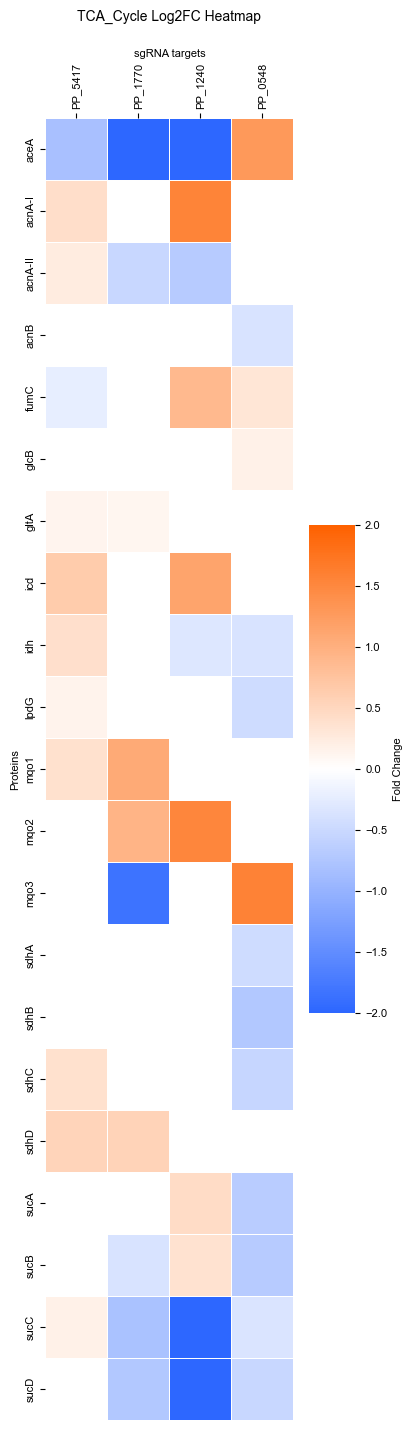

Filtered fold change results saved to 'OxPhos_fc_results.csv'

26 out of 53 genes in the OxPhos were significantly changed across strains


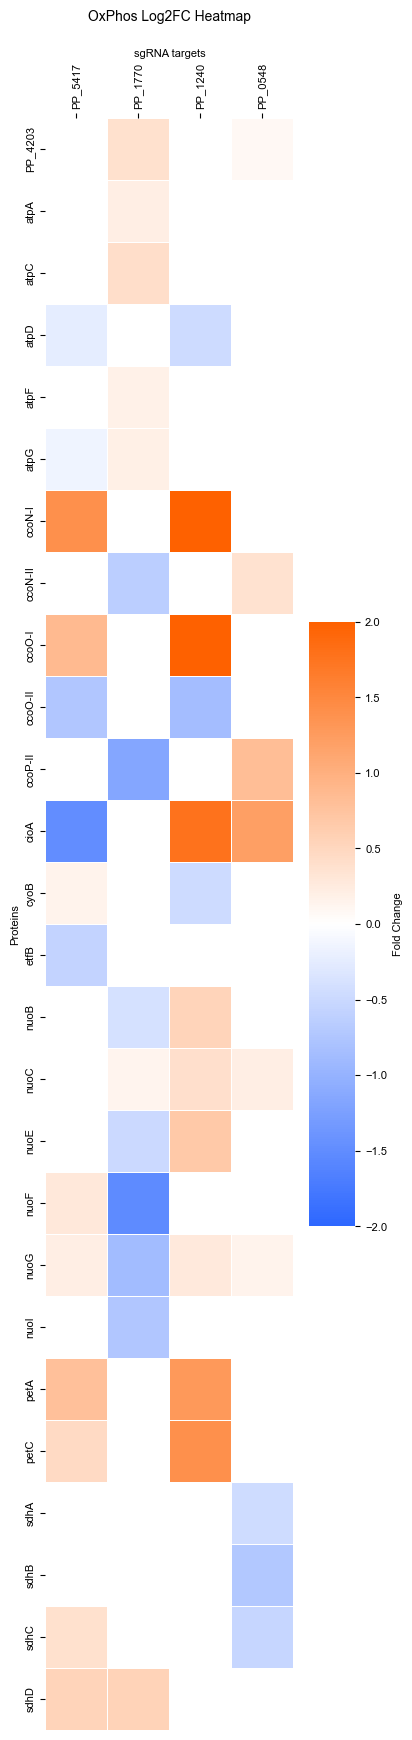

Filtered fold change results saved to 'Ubiquinone_Biosynthesis_fc_results.csv'

4 out of 8 genes in the Ubiquinone_Biosynthesis were significantly changed across strains


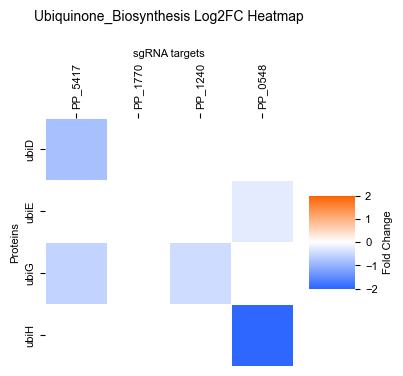

Filtered fold change results saved to 'Isoprenoid_Biosynthesis_fc_results.csv'

4 out of 12 genes in the Isoprenoid_Biosynthesis were significantly changed across strains


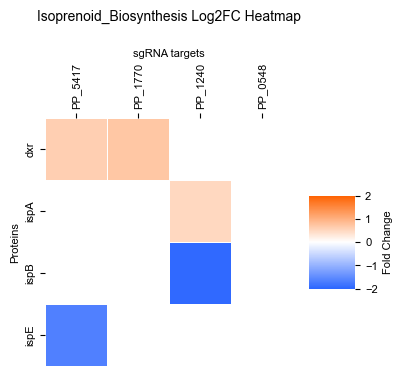

Filtered fold change results saved to 'Glucose_Metabolism_fc_results.csv'

25 out of 35 genes in the Glucose_Metabolism were significantly changed across strains


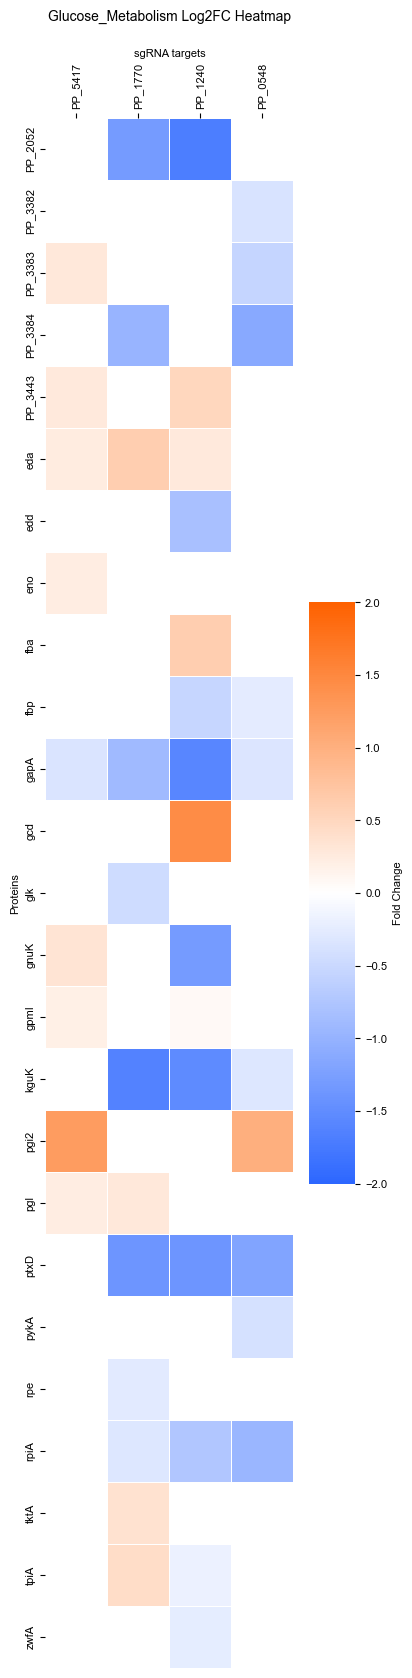

Filtered fold change results saved to 'FAD_FAB_fc_results.csv'

20 out of 73 genes in the FAD_FAB were significantly changed across strains


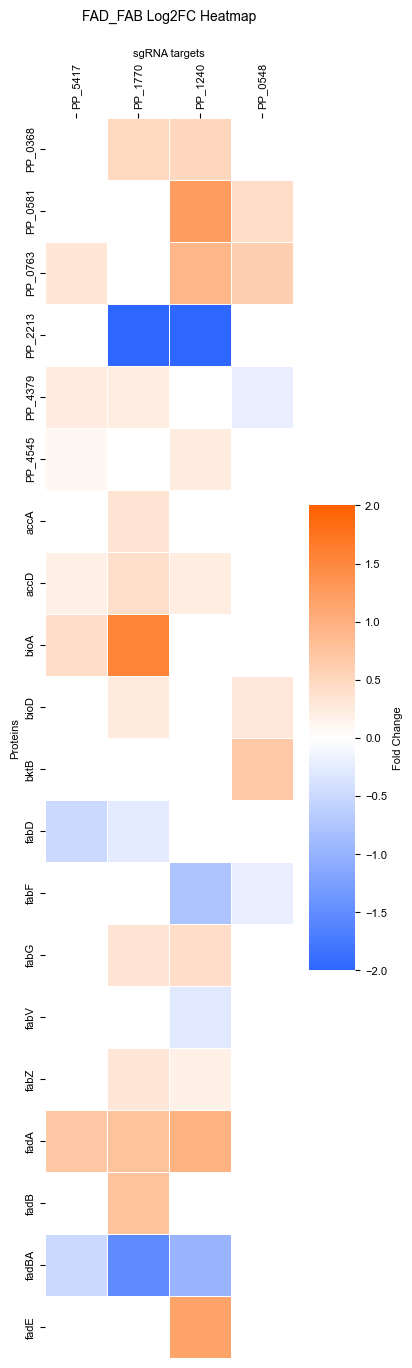

Filtered fold change results saved to 'NH4_Assimilation_Ext_fc_results.csv'

11 out of 19 genes in the NH4_Assimilation_Ext were significantly changed across strains


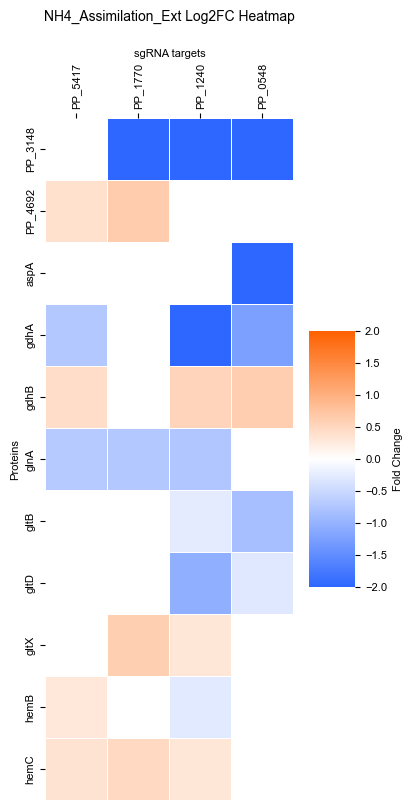

Filtered fold change results saved to 'BC_AA_Synthesis_fc_results.csv'

10 out of 27 genes in the BC_AA_Synthesis were significantly changed across strains


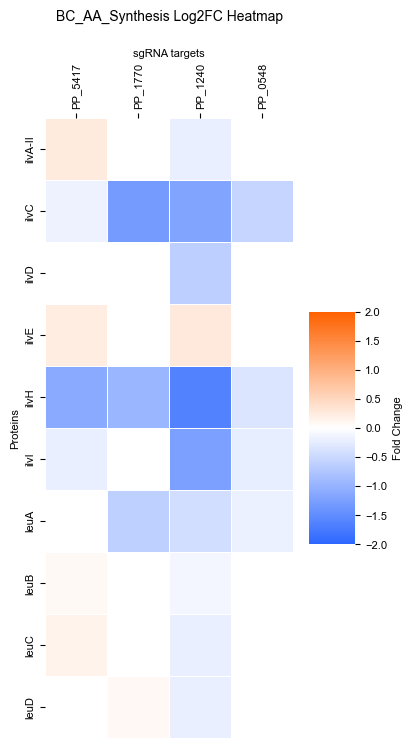

Filtered fold change results saved to 'Biotin_Biosynthesis_fc_results.csv'

12 out of 40 genes in the Biotin_Biosynthesis were significantly changed across strains


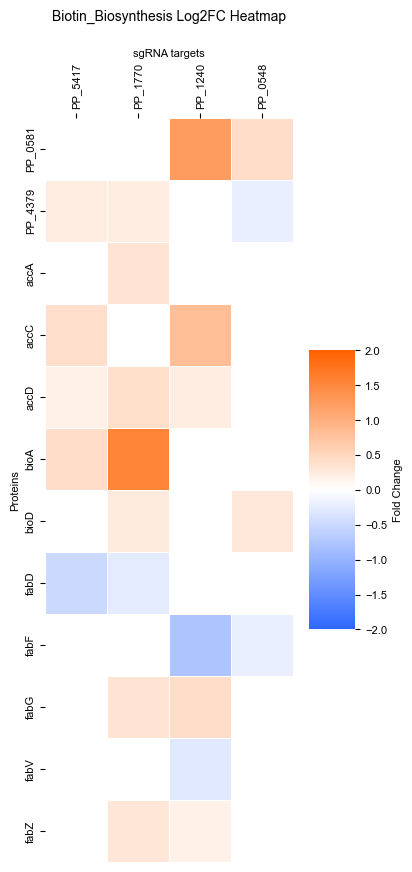

Filtered fold change results saved to 'pyruvate_to_aceCoA_fc_results.csv'

4 out of 4 genes in the pyruvate_to_aceCoA were significantly changed across strains


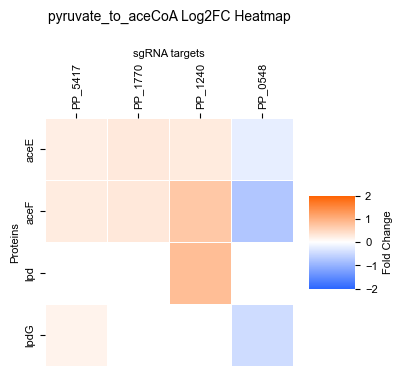

In [11]:
for analysis_name in analysis_list:
    
    proteins_txt = pd.read_csv(f'Pathways/{analysis_name}.txt', delimiter='\t')
    
    # Clean analysis_name file of duplicates and use locus number if gene accession is blank
    proteins_txt = proteins_txt.drop_duplicates()
    proteins_txt['Gene Accession'] = proteins_txt['Gene Accession'].str.strip()
    proteins_txt['Gene Accession'] = proteins_txt['Gene Accession'].map(map_protein_group2)
    gene_list = proteins_txt['Gene Accession'].tolist()
    log2_log10_results['Protein.Group'] = log2_log10_results['Protein.Group'].str.strip()
    
    # Filter the log2_log10_results to include only the proteins in the gene list
    filtered_results = log2_log10_results[log2_log10_results['Protein.Group'].isin(gene_list)]
    fc_columns = [col for col in filtered_results.columns if col.endswith('_FC')]
    filtered_fc_results = filtered_results[['Protein.Group'] + fc_columns]
    
    # Save the filtered results to a CSV file in Figure_Export
    output_file = os.path.join(output_dir, f'{analysis_name}_fc_results.csv')
    filtered_fc_results.to_csv(output_file, index=False)
    print(f"Filtered fold change results saved to '{analysis_name}_fc_results.csv'")
    
    
    # Provide a list of the genes that were changed from the provided  list
    included = filtered_fc_results.shape[0]
    total = len(proteins_txt)
    ratio = ratio = included / total
    print("")
    print(f"{included} out of {total} genes in the {analysis_name} were significantly changed across strains")
    
    # Heatmap generation
    filtered_fc_results.set_index('Protein.Group', inplace=True)
    filtered_fc_results.columns = [col.replace('_log2_FC', '') for col in filtered_fc_results.columns]
    filtered_fc_results = filtered_fc_results.sort_index()
    
    # Set heatmap properties (Font, min, max, size)
    plt.rcParams['font.size'] = 8  
    plt.rcParams['font.family'] = 'Arial' 
    
    num_rows, num_cols = filtered_fc_results.shape
    aspect_ratio = num_cols / num_rows
    vmin = -2
    vmax = 2
    
    # Generate the heatmap with custom colors
    fig, ax = plt.subplots(figsize=(4, 4 / aspect_ratio)) 
    heatmap = sns.heatmap(
        filtered_fc_results, 
        cmap=custom_cmap, 
        annot=False, 
        cbar_kws={'label': 'Fold Change', 'shrink': 0.5, 'aspect': num_rows/2},  
        linewidths=.5, 
        ax=ax, 
        square=True,
        vmin=vmin,
        vmax=vmax
    )
    
    # Reposition x-axis labels
    heatmap.xaxis.set_ticks_position('top')
    heatmap.xaxis.set_label_position('top')
    plt.xticks(rotation=90, fontsize=8)  # Set the font size for x-axis labels
    plt.yticks(fontsize=8)  # Set the font size for y-axis labels
    
    # Add title and y-axis labels
    plt.title(f'{analysis_name} Log2FC Heatmap', pad=20, fontsize=10)  # Set the font size for the title
    plt.xlabel('sgRNA targets', fontsize=8)  # Set the font size for x-axis label
    plt.ylabel('Proteins', fontsize=8)  # Set the font size for y-axis label
    
    # Save the heatmap as an image file
    output_file = os.path.join(output_dir, f'{analysis_name}_fc_heatmap.pdf')
    plt.savefig(output_file, dpi=400, bbox_inches='tight')
    plt.show()